# Example 14: RVT SRA with multiple motions and simulated profiles

Example with multiple input motions and simulated soil profiles.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import pystrata

%matplotlib inline

In [ ]:
# Increased figure sizes
plt.rcParams["figure.dpi"] = 120

## Create a point source theory RVT motion

In [ ]:
motions = [
    pystrata.motion.SourceTheoryRvtMotion(5.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(6.0, 30, "wna"),
    pystrata.motion.SourceTheoryRvtMotion(7.0, 30, "wna"),
]

for m in motions:
    m.calc_fourier_amps()

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [ ]:
profile = pystrata.site.Profile(
    [
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=100),
            10,
            400,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=200),
            10,
            450,
        ),
        pystrata.site.Layer(
            pystrata.site.DarendeliSoilType(18.0, plas_index=0, ocr=1, stress_mean=400),
            30,
            600,
        ),
        pystrata.site.Layer(pystrata.site.SoilType("Rock", 24.0, None, 0.01), 0, 1200),
    ]
)

## Create the site response calculator

In [ ]:
calc = pystrata.propagation.EquivalentLinearCalculator()

## Initialize the variations

In [ ]:
var_thickness = pystrata.variation.ToroThicknessVariation()
var_velocity = pystrata.variation.DepthDependToroVelVariation.generic_model("USGS C")
var_soiltypes = pystrata.variation.SpidVariation(
    -0.5, std_mod_reduc=0.15, std_damping=0.30
)

## Specify the output

In [ ]:
freqs = np.logspace(-1, 2, num=500)

outputs = pystrata.output.OutputCollection(
    [
        pystrata.output.ResponseSpectrumOutput(
            # Frequency
            freqs,
            # Location of the output
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.ResponseSpectrumRatioOutput(
            # Frequency
            freqs,
            # Location in (denominator),
            pystrata.output.OutputLocation("outcrop", index=-1),
            # Location out (numerator)
            pystrata.output.OutputLocation("outcrop", index=0),
            # Damping
            0.05,
        ),
        pystrata.output.InitialVelProfile(),
        pystrata.output.MaxAccelProfile(),
    ]
)

## Perform the calculation

In [ ]:
count = 20
outputs.reset()
for i, p in enumerate(
    pystrata.variation.iter_varied_profiles(
        profile,
        count,
        # var_thickness=var_thickness,
        var_velocity=var_velocity,
        # var_soiltypes=var_soiltypes
    )
):
    # Here we auto-descretize the profile for wave propagation purposes
    p = p.auto_discretize()
    for j, m in enumerate(motions):
        name = (f"p{i}", f"m{j}")
        calc(m, p, p.location("outcrop", index=-1))
        outputs(calc, name=name)

AttributeError: module 'numpy' has no attribute 'trapezoid'

## Plot the outputs

Create a few plots of the output.

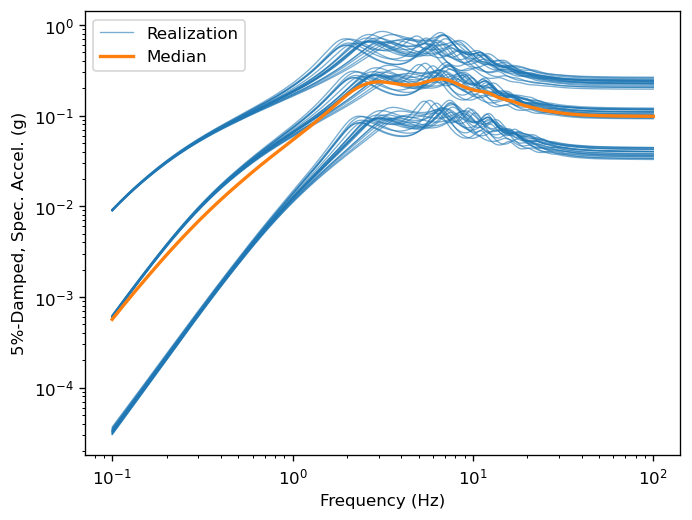

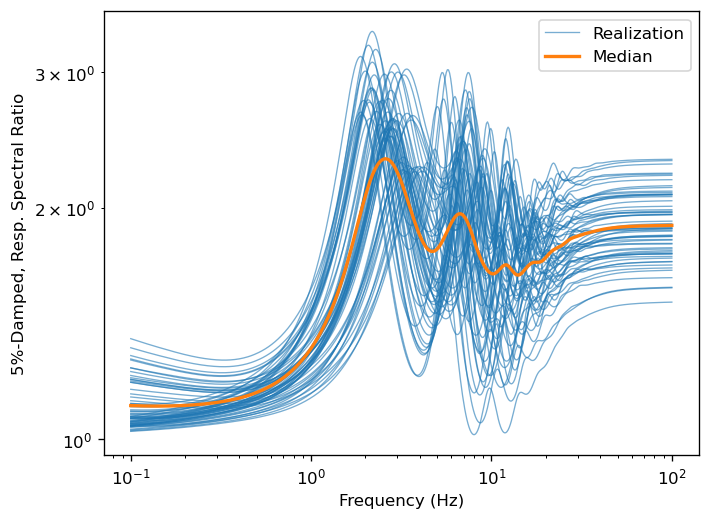

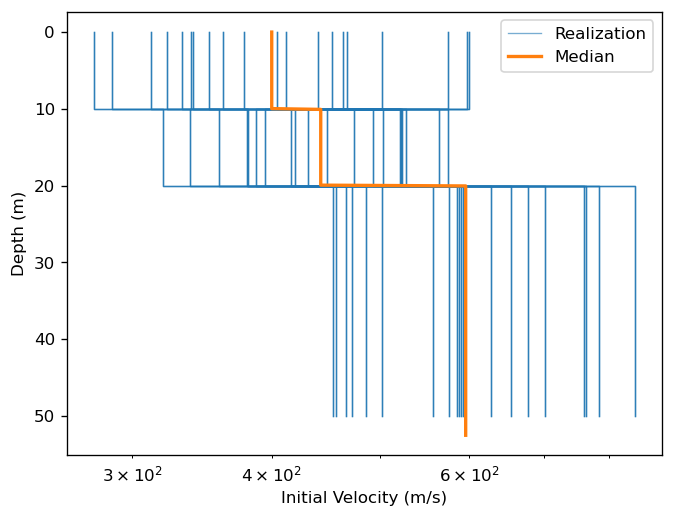

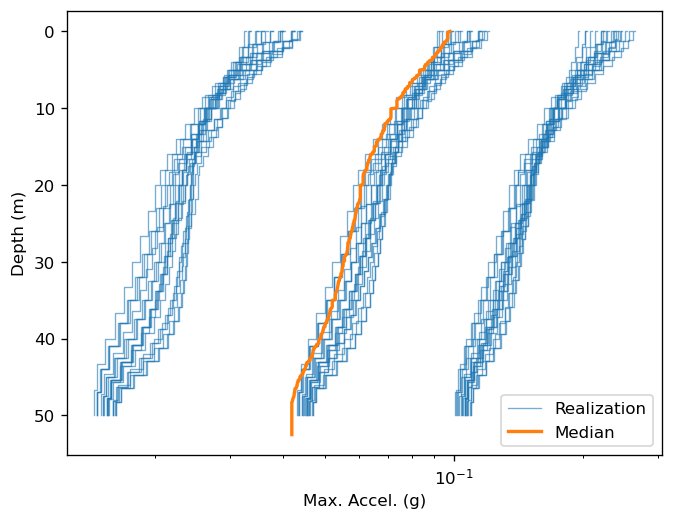

In [ ]:
for o in outputs:
    ax = o.plot(style="stats")

## Manipulating output as dataframe

If a `tuple` is passed as the output name, it is used to create a `pandas.MultiIndex` columns.

In [ ]:
df = outputs[1].to_dataframe()
df

p0                            p1                      \
                  m0        m1        m2        m0        m1        m2   
0.100000    1.284369  1.092001  1.056784  1.190621  1.065394  1.041374   
0.101394    1.283244  1.091908  1.057212  1.190017  1.065351  1.041696   
0.102807    1.282123  1.091821  1.057645  1.189414  1.065312  1.042022   
0.104240    1.281005  1.091740  1.058083  1.188814  1.065278  1.042351   
0.105693    1.279892  1.091666  1.058525  1.188216  1.065250  1.042683   
...              ...       ...       ...       ...       ...       ...   
94.613238   2.081787  1.958323  1.757714  2.210523  2.080894  1.959642   
95.932095   2.081870  1.958414  1.757828  2.210576  2.080943  1.959720   
97.269336   2.081950  1.958503  1.757937  2.210628  2.080991  1.959796   
98.625218   2.082028  1.958589  1.758044  2.210678  2.081038  1.959870   
100.000000  2.082103  1.958673  1.758147  2.210727  2.081083  1.959941   

                  p2                            p3  ...       p16       p17  \
                  m0        m1        m2        m0  ...        m2        m0   
0.100000    1.134724  1.045801  1.028062  1.185366  ...  1.045627  1.237963   
0.101394    1.134335  1.045783  1.028288  1.184749  ...  1.045978  1.237058   
0.102807    1.133948  1.045768  1.028516  1.184135  ...  1.046332  1.236156   
0.104240    1.133562  1.045757  1.028747  1.183522  ...  1.046690  1.235257   
0.105693    1.133177  1.045751  1.028980  1.182912  ...  1.047051  1.234361   
...              ...       ...       ...       ...  ...       ...       ...   
94.613238   1.878152  1.793564  1.727769  1.973260  ...  2.040797  1.750444   
95.932095   1.878184  1.793586  1.727803  1.973314  ...  2.040900  1.750544   
97.269336   1.878215  1.793607  1.727837  1.973365  ...  2.040999  1.750640   
98.625218   1.878245  1.793627  1.727869  1.973415  ...  2.041095  1.750734   
100.000000  1.878274  1.793646  1.727900  1.973464  ...  2.041189  1.750825   

                                     p18                           p19  \
                  m1        m2        m0        m1        m2        m0   
0.100000    1.078481  1.048781  1.267445  1.086630  1.053188  1.210131   
0.101394    1.078410  1.049154  1.266376  1.086544  1.053592  1.209390   
0.102807    1.078345  1.049531  1.265310  1.086464  1.054001  1.208650   
0.104240    1.078286  1.049913  1.264249  1.086390  1.054415  1.207914   
0.105693    1.078232  1.050298  1.263191  1.086322  1.054833  1.207180   
...              ...       ...       ...       ...       ...       ...   
94.613238   1.700148  1.572393  1.814630  1.742832  1.575050  1.919988   
95.932095   1.700247  1.572506  1.814714  1.742923  1.575157  1.920060   
97.269336   1.700343  1.572616  1.814796  1.743012  1.575261  1.920130   
98.625218   1.700436  1.572723  1.814874  1.743097  1.575361  1.920197   
100.000000  1.700526  1.572826  1.814951  1.743180  1.575459  1.920262   

                                
                  m1        m2  
0.100000    1.070370  1.043801  
0.101394    1.070315  1.044140  
0.102807    1.070265  1.044482  
0.104240    1.070220  1.044828  
0.105693    1.070181  1.045178  
...              ...       ...  
94.613238   1.838886  1.718941  
95.932095   1.838955  1.719029  
97.269336   1.839022  1.719113  
98.625218   1.839087  1.719195  
100.000000  1.839149  1.719274  

[500 rows x 60 columns]

Lets names to the dataframe and transform into a long format. Pandas works better on long formatted tables.

In [ ]:
# Add names for clarity
df.columns.names = ("profile", "motion")
df.index.name = "freq"
# Transform into a long format
df = df.melt(ignore_index=False).reset_index().set_index(["freq", "profile", "motion"])
df

,,,value
freq,profile,motion,
0.100000,p0,m0,1.284369
0.101394,p0,m0,1.283244
0.102807,p0,m0,1.282123
0.104240,p0,m0,1.281005
0.105693,p0,m0,1.279892
...,...,...,...
94.613238,p19,m2,1.718941
95.932095,p19,m2,1.719029
97.269336,p19,m2,1.719113


In [ ]:
def calc_stats(group):
    ln_value = np.log(group["value"])

    median = np.exp(np.mean(ln_value))
    ln_std = np.std(ln_value)

    return pd.Series({"median": median, "ln_std": ln_std})


stats = df.groupby(level=["freq", "motion"]).apply(calc_stats)
stats

median    ln_std
freq       motion                    
0.100000   m0      1.210044  0.050617
           m1      1.070422  0.017717
           m2      1.044044  0.011516
0.101394   m0      1.209315  0.050400
           m1      1.070366  0.017689
...                     ...       ...
98.625218  m1      1.908067  0.083895
           m2      1.779801  0.081327
100.000000 m0      2.006814  0.095733
           m1      1.908128  0.083894
           m2      1.779881  0.081322

[1500 rows x 2 columns]

In [ ]:
stats = (
    stats.reset_index("motion")
    .pivot(columns="motion")
    .swaplevel(0, 1, axis=1)
    .sort_index(axis=1)
)
stats

motion            m0                  m1                  m2          
              ln_std    median    ln_std    median    ln_std    median
freq                                                                  
0.100000    0.050617  1.210044  0.017717  1.070422  0.011516  1.044044
0.101394    0.050400  1.209315  0.017689  1.070366  0.011592  1.044382
0.102807    0.050183  1.208588  0.017662  1.070315  0.011668  1.044724
0.104240    0.049966  1.207863  0.017635  1.070269  0.011746  1.045069
0.105693    0.049750  1.207141  0.017609  1.070229  0.011824  1.045418
...              ...       ...       ...       ...       ...       ...
94.613238   0.095744  2.006546  0.083900  1.907872  0.081342  1.779545
95.932095   0.095741  2.006616  0.083898  1.907939  0.081337  1.779633
97.269336   0.095739  2.006684  0.083897  1.908004  0.081332  1.779718
98.625218   0.095736  2.006750  0.083895  1.908067  0.081327  1.779801
100.000000  0.095733  2.006814  0.083894  1.908128  0.081322  1.779881

[500 rows x 6 columns]

Access the properties of each motion like:

In [ ]:
stats["m0"]

,ln_std,median
freq,,
0.100000,0.050617,1.210044
0.101394,0.050400,1.209315
0.102807,0.050183,1.208588
0.104240,0.049966,1.207863
0.105693,0.049750,1.207141
...,...,...
94.613238,0.095744,2.006546
95.932095,0.095741,2.006616
97.269336,0.095739,2.006684


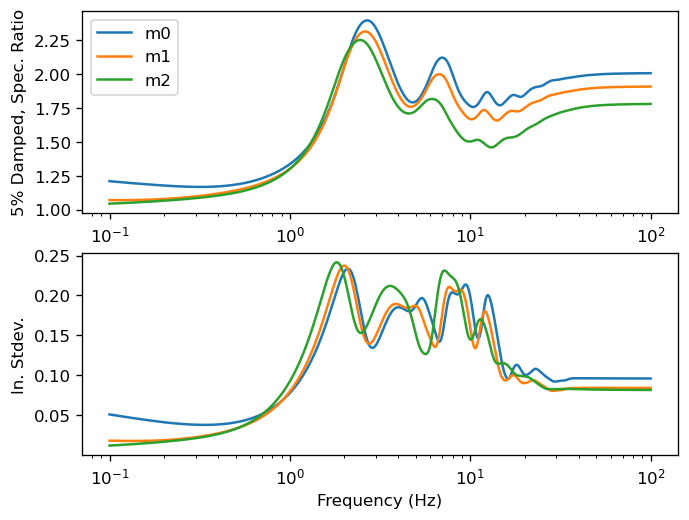

In [ ]:
fig, axes = plt.subplots(nrows=2, subplot_kw={"xscale": "log"})

for name, g in stats.T.groupby(level=0):
    for ax, key in zip(axes, ["median", "ln_std"]):
        ax.plot(g.columns, g.loc[name, key], label=name)


axes[0].set(ylabel="5% Damped, Spec. Ratio")
axes[0].legend()

axes[1].set(ylabel="ln. Stdev.", xlabel="Frequency (Hz)")

fig;